In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import numpy as np

# Load the compressed .npz file
data = np.load("/content/drive/MyDrive/processed/X_train_standardized_mapped.npz")

# Extract arrays from the loaded data
X_train_standardized = data["X"]
y_train_combined = data["y"]
mean = data["mean"]
std = data["std"]

# Optional: check shapes to confirm successful load
print("X shape:", X_train_standardized.shape)
print("y shape:", y_train_combined.shape)
print("mean shape:", mean.shape)
print("std shape:", std.shape)

X shape: (15175, 6, 128)
y shape: (15175,)
mean shape: (1, 6, 1)
std shape: (1, 6, 1)


In [ ]:
from sklearn.model_selection import train_test_split

X = data["X"]
y = data["y"]

# Split into train and test (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # stratify keeps class balance
)

# Check shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (12140, 6, 128)
X_test shape: (3035, 6, 128)
y_train shape: (12140,)
y_test shape: (3035,)


In [ ]:
X_train.shape

(12140, 6, 128)

In [ ]:
X_train = np.transpose(X_train, (0, 2, 1))
X_test = np.transpose(X_test, (0, 2, 1))
print("New shape:", X_train.shape)  # → (12140, 128, 6)


New shape: (12140, 128, 6)


In [ ]:
import numpy as np

# Get all unique classes and sort
unique_classes = np.unique(y_train_combined)
print("Unique labels:", unique_classes)

import numpy as np

# Manually map raw labels to new class indices
label_mapping = {
    1: 0,          # WALKING
    2: 1, 12: 1,   # WALKING_UPSTAIRS (merged)
    3: 2, 13: 2,   # WALKING_DOWNSTAIRS (merged)
    4: 3,          # SITTING
    5: 4,          # STANDING
    6: 5           # LAYING
}

# Apply to both training and testing labels
y_train = np.array([label_mapping[label] for label in y_train])
y_test = np.array([label_mapping[label] for label in y_test])

# Show results
print("Unique mapped train labels:", np.unique(y_train))
print("Unique mapped test labels:", np.unique(y_test))


Unique labels: [ 1  2  3  4  5  6 12 13]
Unique mapped train labels: [0 1 2 3 4 5]
Unique mapped test labels: [0 1 2 3 4 5]


FUNCTIONAL API , CNN+LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, ReLU, MaxPooling1D, Dropout,
    Bidirectional, LSTM, Dense, GlobalAveragePooling1D, Attention,LayerNormalization
)
from tensorflow.keras.utils import to_categorical
import numpy as np

def har_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Convolutional Feature Extractor
    x = Conv1D(64, kernel_size=3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(256, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(pool_size=2)(x)

    # Recurrent Temporal Model

    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.5)(x)

    # Attention Layer
    attention = Attention()([x, x])
    x = GlobalAveragePooling1D()(attention)

    # Dense Output Layer
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
# One-hot encode the labels
num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Define input shape
input_shape = X_train.shape[1:]  # (timesteps, features)
# Build model
model = har_model(input_shape, num_classes)

# Show summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 6)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 128, 64)   │      1,216 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 64)   │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 128, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 64, 64)    │          0 │ re_lu[0][0]       │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 64, 128)   │     24,704 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128)   │        512 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 64, 128)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 32, 128)   │          0 │ re_lu_1[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 32, 256)   │     98,560 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 256)   │      1,024 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 32, 256)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 16, 256)   │          0 │ re_lu_2[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 16, 128)   │    197,120 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 128)   │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 16, 128)   │          0 │ dropout[0][0],    │
│ (Attention)         │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ attention[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 6)         │        390 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 332,038 (1.27 MB)

 Trainable params: 331,142 (1.26 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=100,
    batch_size=64,
#     callbacks = [
#     tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
#     tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6)
# ]

)

Epoch 1/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5565 - loss: 1.0704 - val_accuracy: 0.6956 - val_loss: 0.6681
Epoch 2/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6988 - loss: 0.6979 - val_accuracy: 0.7226 - val_loss: 0.5874
Epoch 3/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7209 - loss: 0.6349 - val_accuracy: 0.7476 - val_loss: 0.5411
Epoch 4/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7274 - loss: 0.5887 - val_accuracy: 0.7631 - val_loss: 0.5244
Epoch 5/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7395 - loss: 0.5651 - val_accuracy: 0.7667 - val_loss: 0.5177
Epoch 6/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7522 - loss: 0.5309 - val_accuracy: 0.7730 - val_loss: 0.4853
Epoch 7/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7452 - loss: 0.5320 - val_accuracy: 0.7684 - val_loss: 0.4912
Epoch 8/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7501 - loss: 0.5279 -

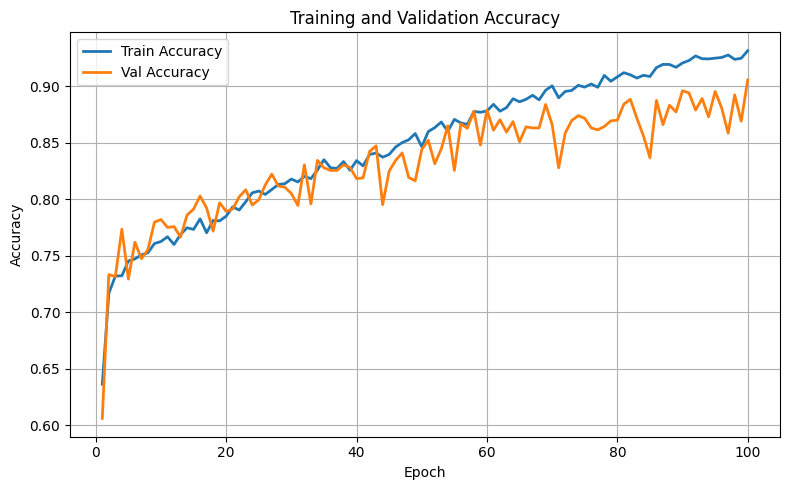

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(epochs, history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

# Calculate Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate F1 Score (macro/weighted for multi-class)
f1 = f1_score(y_true, y_pred, average='weighted')  # or 'macro'

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"F1 Score: {f1:.4f}")


Test Accuracy: 90.58%
F1 Score: 0.9057


In [ ]:
sample_idx = 1660  # change as needed
sample = X_test[sample_idx:sample_idx+1]  # keep batch dimension
predicted_class = np.argmax(model.predict(sample), axis=1)[0]
actual_class = np.argmax(y_test_cat[sample_idx])

print(f"Predicted: {predicted_class}, Actual: {actual_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
Predicted: 2, Actual: 2


In [ ]:
import numpy as np

# Ensure consistent results across runs


# Generate 10 random indices
random_indices = np.random.choice(len(X_test), size=10, replace=False)

# Predict
y_pred_proba = model.predict(X_test[random_indices])
y_pred = np.argmax(y_pred_proba, axis=1)
y_actual = np.argmax(y_test_cat[random_indices], axis=1)

# Display predictions
print("Sample\tPredicted\tActual")
for i, idx in enumerate(random_indices):
    print(f"{i+1}\t{y_pred[i]}\t\t{y_actual[i]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Sample	Predicted	Actual
1	2		2
2	4		4
3	0		0
4	2		2
5	0		0
6	2		2
7	4		5
8	1		2
9	0		0
10	2		2


#**CNN**

In [ ]:
def cnn_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv1D(64, 3, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(2)(x)

    x = Conv1D(128, 3, activation='relu', padding='same')(x)
    x = MaxPooling1D(2)(x)

    x = Conv1D(128, 3, activation='relu', padding='same')(x)
    x = MaxPooling1D(2)(x)

    x = Conv1D(128, 3, activation='relu', padding='same')(x)
    x = MaxPooling1D(2)(x)

    x = Conv1D(256, 3, activation='relu', padding='same')(x)
    x = MaxPooling1D(2)(x)

    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# One-hot encode the labels
num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Define input shape
input_shape = X_train.shape[1:]  # (timesteps, features)
# Build model
cnnmodel = cnn_model(input_shape, num_classes)

# Show summary
cnnmodel.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 6)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 128, 64)        │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 64, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 32, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 16, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 8, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 4, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 239,878 (937.02 KB)

 Trainable params: 239,878 (937.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = cnnmodel.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=100,
    batch_size=64,
#     callbacks = [
#     tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
#     tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6)
# ]

)

Epoch 1/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.4901 - loss: 1.1847 - val_accuracy: 0.7176 - val_loss: 0.6429
Epoch 2/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6895 - loss: 0.7116 - val_accuracy: 0.7509 - val_loss: 0.5320
Epoch 3/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7382 - loss: 0.5959 - val_accuracy: 0.7344 - val_loss: 0.5643
Epoch 4/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7423 - loss: 0.5685 - val_accuracy: 0.7588 - val_loss: 0.4865
Epoch 5/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7572 - loss: 0.5133 - val_accuracy: 0.7713 - val_loss: 0.5039
Epoch 6/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7585 - loss: 0.5103 - val_accuracy: 0.7549 - val_loss: 0.5432
Epoch 7/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7505 - loss: 0.5135 - val_accuracy: 0.7809 - val_loss: 0.4572
Epoch 8/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7630 - loss: 0.4902 - val_ac

#**CNN + biLSTM**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, MaxPooling1D, Dropout
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, GlobalAveragePooling1D, Attention
from tensorflow.keras.utils import to_categorical

# One-hot encode y
num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Input shape (timesteps, features)
input_shape = X_train.shape[1:]
inputs = Input(shape=input_shape)

# Convolutional Feature Extractor
x = Conv1D(64, kernel_size=3, padding='same')(inputs)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(128, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(128, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling1D(pool_size=2)(x)

# 3rd Conv block
x = Conv1D(256, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling1D(pool_size=2)(x)


# Recurrent Temporal Model
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Dropout(0.5)(x)

# Attention Layer (optional but boosts performance)
attention = tf.keras.layers.Attention()([x, x])
x = GlobalAveragePooling1D()(attention)

# Dense Output Layer
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 128, 6)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_54 (Conv1D)  │ (None, 128, 64)   │      1,216 │ input_layer_21[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_54[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_44 (ReLU)     │ (None, 128, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_54    │ (None, 64, 64)    │          0 │ re_lu_44[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_55 (Conv1D)  │ (None, 64, 128)   │     24,704 │ max_pooling1d_54… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128)   │        512 │ conv1d_55[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_45 (ReLU)     │ (None, 64, 128)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_55    │ (None, 32, 128)   │          0 │ re_lu_45[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_56 (Conv1D)  │ (None, 32, 128)   │     49,280 │ max_pooling1d_55… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 128)   │        512 │ conv1d_56[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_46 (ReLU)     │ (None, 32, 128)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_56    │ (None, 16, 128)   │          0 │ re_lu_46[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_57 (Conv1D)  │ (None, 16, 256)   │     98,560 │ max_pooling1d_56… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 256)   │      1,024 │ conv1d_57[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_47 (ReLU)     │ (None, 16, 256)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_57    │ (None, 8, 256)    │          0 │ re_lu_47[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_18    │ (None, 8, 256)    │    394,240 │ max_pooling1d_57… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_78          │ (None, 8, 256)    │          0 │ bidirectional_18… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 587,272 (2.24 MB)

 Trainable params: 586,120 (2.24 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [ ]:
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=50,
    batch_size=64,
    # callbacks=[
    #     tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    # ]
)

Epoch 1/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.5577 - loss: 1.1412 - val_accuracy: 0.6913 - val_loss: 0.6904
Epoch 2/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6970 - loss: 0.7163 - val_accuracy: 0.7552 - val_loss: 0.5678
Epoch 3/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7173 - loss: 0.6532 - val_accuracy: 0.7460 - val_loss: 0.5929
Epoch 4/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7342 - loss: 0.6122 - val_accuracy: 0.7552 - val_loss: 0.5226
Epoch 5/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7381 - loss: 0.5814 - val_accuracy: 0.7430 - val_loss: 0.5648
Epoch 6/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7471 - loss: 0.5658 - val_accuracy: 0.7746 - val_loss: 0.5061
Epoch 7/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.7420 - loss: 0.5725 - val_accuracy: 0.7568 - val_loss: 0.5232
Epoch 8/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7609 - loss: 0.5344 - val_accu

In [ ]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 83.72%


In [ ]:
sample_idx = 1560  # change as needed
sample = X_test[sample_idx:sample_idx+1]  # keep batch dimension
predicted_class = np.argmax(model.predict(sample), axis=1)[0]
actual_class = np.argmax(y_test_cat[sample_idx])

print(f"Predicted: {predicted_class}, Actual: {actual_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted: 3, Actual: 3


In [ ]:
import numpy as np

# Ensure consistent results across runs


# Generate 10 random indices
random_indices = np.random.choice(len(X_test), size=10, replace=False)

# Predict
y_pred_proba = model.predict(X_test[random_indices])
y_pred = np.argmax(y_pred_proba, axis=1)
y_actual = np.argmax(y_test_cat[random_indices], axis=1)

# Display predictions
print("Sample\tPredicted\tActual")
for i, idx in enumerate(random_indices):
    print(f"{i+1}\t{y_pred[i]}\t\t{y_actual[i]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Sample	Predicted	Actual
1	2		2
2	1		1
3	2		2
4	2		0
5	1		1
6	7		7
7	0		0
8	2		1
9	3		3
10	3		3


#**SEQUENTIAL API , CNN+LSTM**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, ReLU, MaxPooling1D, Dropout
from tensorflow.keras.layers import Bidirectional, LSTM, GlobalAveragePooling1D, Dense

model = Sequential([
    Conv1D(64, 3, padding='same', input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    ReLU(),
    MaxPooling1D(pool_size=2),

    Conv1D(128, 3, padding='same', activation='relu'),
    BatchNormalization(),
    ReLU(),
    MaxPooling1D(pool_size=2),

    Conv1D(128, 3, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling1D(pool_size=2),

    Conv1D(256, 3, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling1D(pool_size=2),

    LSTM(128, return_sequences=True),
    Dropout(0.5),

    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),

    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 128, 64)        │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 64, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 32, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 16, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 16, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 8, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 8, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 8, 256)         │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 8, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 653,190 (2.49 MB)

 Trainable params: 652,038 (2.49 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [ ]:
from tensorflow.keras.utils import to_categorical
import numpy as np

# One-hot encoding
num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Train the model
# model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), epochs=10, batch_size=32)

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=100,
    batch_size=64,
    # callbacks=[
    #     tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    # ]
)

Epoch 1/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.5509 - loss: 1.0506 - val_accuracy: 0.6063 - val_loss: 1.0272
Epoch 2/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7074 - loss: 0.6772 - val_accuracy: 0.7334 - val_loss: 0.5622
Epoch 3/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7339 - loss: 0.5862 - val_accuracy: 0.7318 - val_loss: 0.5780
Epoch 4/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7261 - loss: 0.5802 - val_accuracy: 0.7736 - val_loss: 0.5058
Epoch 5/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7446 - loss: 0.5495 - val_accuracy: 0.7295 - val_loss: 0.5502
Epoch 6/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.7406 - loss: 0.5430 - val_accuracy: 0.7621 - val_loss: 0.4841
Epoch 7/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7480 - loss: 0.5300 - val_accuracy: 0.7476 - val_loss: 0.5031
Epoch 8/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7583 - loss: 0.5244 -

In [ ]:
from sklearn.metrics import f1_score
import numpy as np

val_preds = model.predict(X_test, verbose=0)
val_preds_epochs = []

# Store model prediction after each epoch from training history
for epoch_probs in history.history['val_accuracy']:
    val_preds_epochs.append(val_preds)  # Same predictions used for all (cannot access historical val preds)

# So instead, simulate F1 manually:
y_pred = np.argmax(val_preds, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Since you only have final predictions, calculate F1 once:
f1_scores = [f1_score(y_true, y_pred, average='weighted')] * len(history.history['val_accuracy'])


In [ ]:
# If you used constant learning rate:
lr = float(tf.keras.backend.get_value(model.optimizer.learning_rate))
lr_schedule = [lr] * len(history.history['loss'])  # Same value across epochs

# If you used a learning rate schedule/callback, use the values it generated


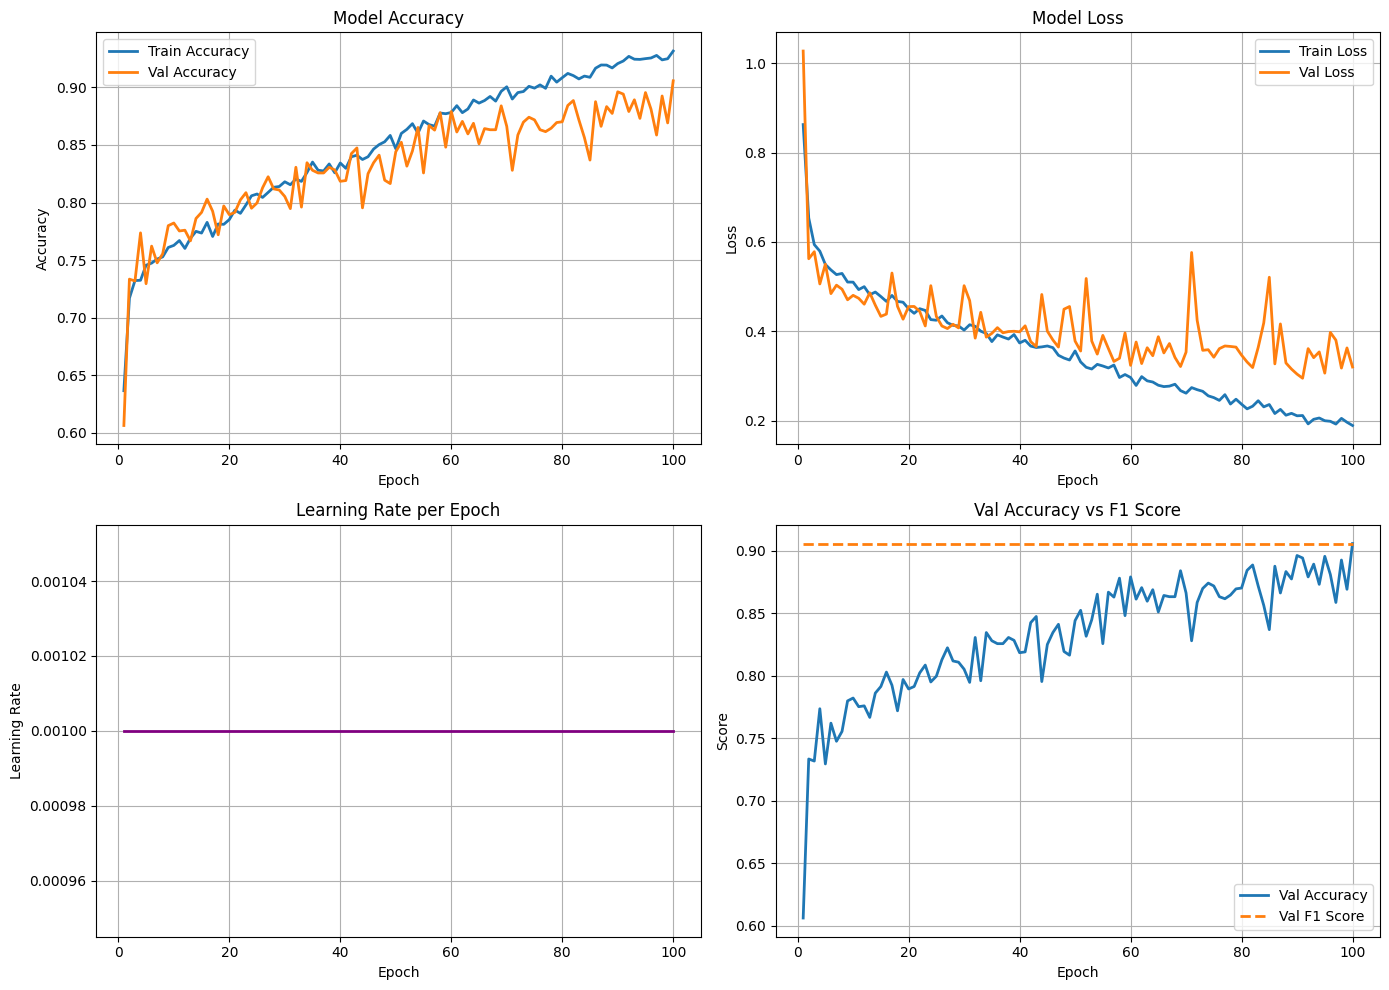

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(14, 10))

# 1. Accuracy
plt.subplot(2, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(epochs, history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 2. Loss
plt.subplot(2, 2, 2)
plt.plot(epochs, history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(epochs, history.history['val_loss'], label='Val Loss', linewidth=2)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 3. Learning Rate
plt.subplot(2, 2, 3)
plt.plot(epochs, lr_schedule, color='purple', linewidth=2)
plt.title('Learning Rate per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)

# 4. F1 Score (static) + Val Accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
plt.plot(epochs, f1_scores, label='Val F1 Score', linestyle='--', linewidth=2)
plt.title('Val Accuracy vs F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Class index to activity name (after mapping)
class_names = {
    0: "WALKING",
    1: "WALKING_UPSTAIRS",
    2: "WALKING_DOWNSTAIRS",
    3: "SITTING",
    4: "STANDING",
    5: "LAYING"
}


In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

# Predict on test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert one-hot encoded y_test to class labels
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

# Unique classes
classes = np.unique(y_true)

# Per-class accuracy dictionary
per_class_acc = {}

print("\n📊 Per-Class Accuracy:")
for cls in classes:
    idxs = np.where(y_true == cls)[0]
    correct = np.sum(y_pred[idxs] == y_true[idxs])
    acc = correct / len(idxs)
    print(f"{class_names[cls]:<20}: {acc * 100:.2f}%")


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

📊 Per-Class Accuracy:
WALKING             : 95.76%
WALKING_UPSTAIRS    : 91.73%
WALKING_DOWNSTAIRS  : 94.90%
SITTING             : 92.01%
STANDING            : 79.64%
LAYING              : 78.29%


/tmp/ipython-input-2074244996.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Blues')


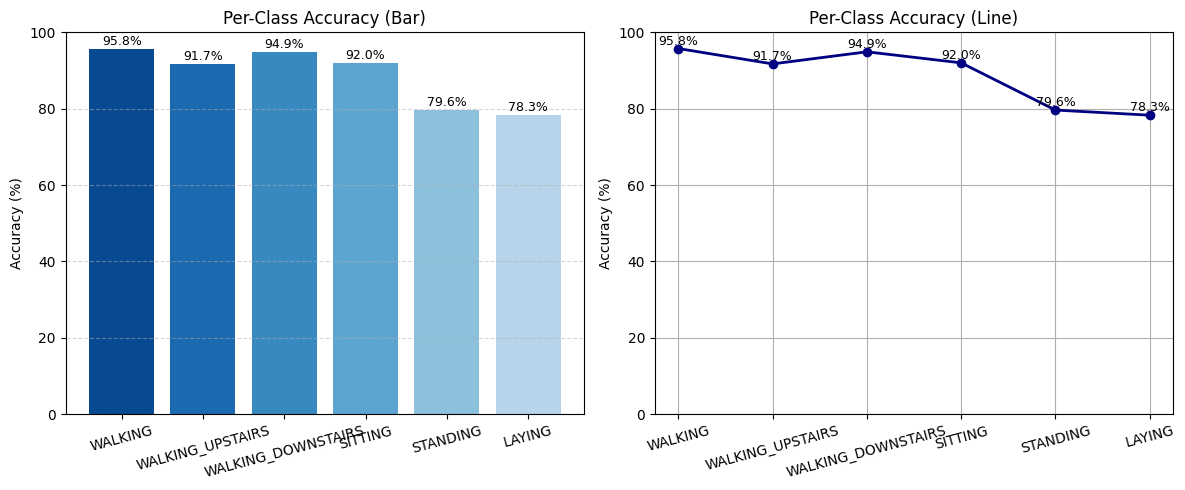

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Compute per-class accuracy
per_class_acc = {}
for cls in classes:
    idxs = np.where(y_true == cls)[0]
    correct = np.sum(y_pred[idxs] == y_true[idxs])
    acc = correct / len(idxs)
    per_class_acc[class_names[cls]] = acc

# Extract labels and values
labels = list(per_class_acc.keys())
values = [v * 100 for v in per_class_acc.values()]

# Generate color shades: dark blue (left) to light blue (right)
cmap = cm.get_cmap('Blues')
num_classes = len(labels)
shades = [cmap(0.9 - 0.6 * (i / (num_classes - 1))) for i in range(num_classes)]  # dark to light L→R

# Plot subplots
plt.figure(figsize=(12, 5))

# Bar Plot
plt.subplot(1, 2, 1)
plt.bar(labels, values, color=shades)
plt.title("Per-Class Accuracy (Bar)")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.xticks(rotation=15)
for i, v in enumerate(values):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Line Plot
plt.subplot(1, 2, 2)
plt.plot(labels, values, marker='o', color='navy', linewidth=2)
plt.title("Per-Class Accuracy (Line)")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.xticks(rotation=15)
for i, v in enumerate(values):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=9)
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure y_true and y_pred are class labels (not one-hot)
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test
y_pred = np.argmax(model.predict(X_test), axis=1)

# Class name mapping
class_names = {
    0: "WALKING",
    1: "WALKING_UPSTAIRS",
    2: "WALKING_DOWNSTAIRS",
    3: "SITTING",
    4: "STANDING",
    5: "LAYING"
}

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


#**CONFUSION MATRIX**

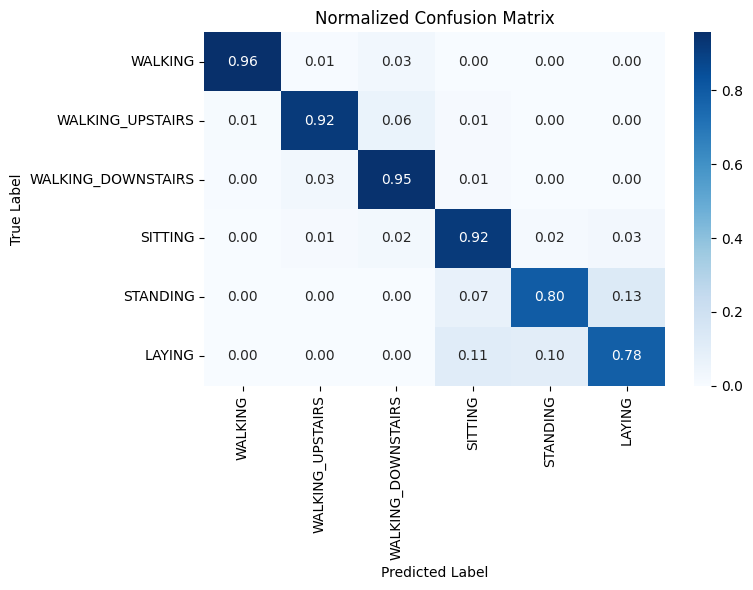

In [ ]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names.values(),
            yticklabels=class_names.values())

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.tight_layout()
plt.show()


#**SAMPLE SIGNAL WINDOW**

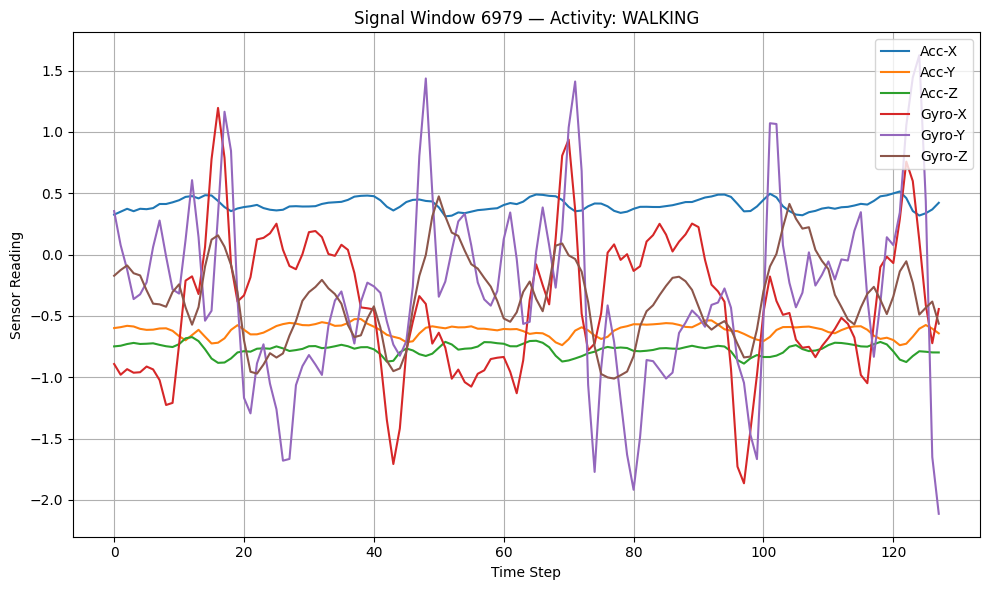

In [ ]:
import matplotlib.pyplot as plt

# Select a window and label
window_index = 6979
signal = X_train[window_index]         # shape: (timesteps, features)
label_index = y_train[window_index]    # numeric label
label_name = class_names[label_index]

# Feature labels (optional)
sensor_channels = ['Acc-X', 'Acc-Y', 'Acc-Z', 'Gyro-X', 'Gyro-Y', 'Gyro-Z']

# Plot
plt.figure(figsize=(10, 6))
for i in range(signal.shape[1]):
    plt.plot(signal[:, i], label=sensor_channels[i])

plt.title(f"Signal Window {window_index} — Activity: {label_name}")
plt.xlabel("Time Step")
plt.ylabel("Sensor Reading")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import random

# Make sure predictions are available
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert y_test to class indices if one-hot
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

# Pick 10 random indices from test set
sample_indices = random.sample(range(len(X_test)), 10)

print("🔍 Random Sample Predictions:")
print("-" * 45)
print(f"{'Index':<6} {'True Label':<20} {'Predicted Label'}")
print("-" * 45)

for idx in sample_indices:
    true_class = class_names[y_true[idx]]
    pred_class = class_names[y_pred[idx]]
    print(f"{idx:<6} {true_class:<20} {pred_class}")


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
🔍 Random Sample Predictions:
---------------------------------------------
Index  True Label           Predicted Label
---------------------------------------------
556    STANDING             STANDING
394    WALKING_DOWNSTAIRS   WALKING_DOWNSTAIRS
2746   WALKING_UPSTAIRS     WALKING_DOWNSTAIRS
1346   WALKING_UPSTAIRS     WALKING_UPSTAIRS
1893   SITTING              SITTING
514    SITTING              SITTING
1110   WALKING_UPSTAIRS     WALKING_UPSTAIRS
1978   SITTING              SITTING
2211   WALKING              WALKING
2386   LAYING               LAYING


95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


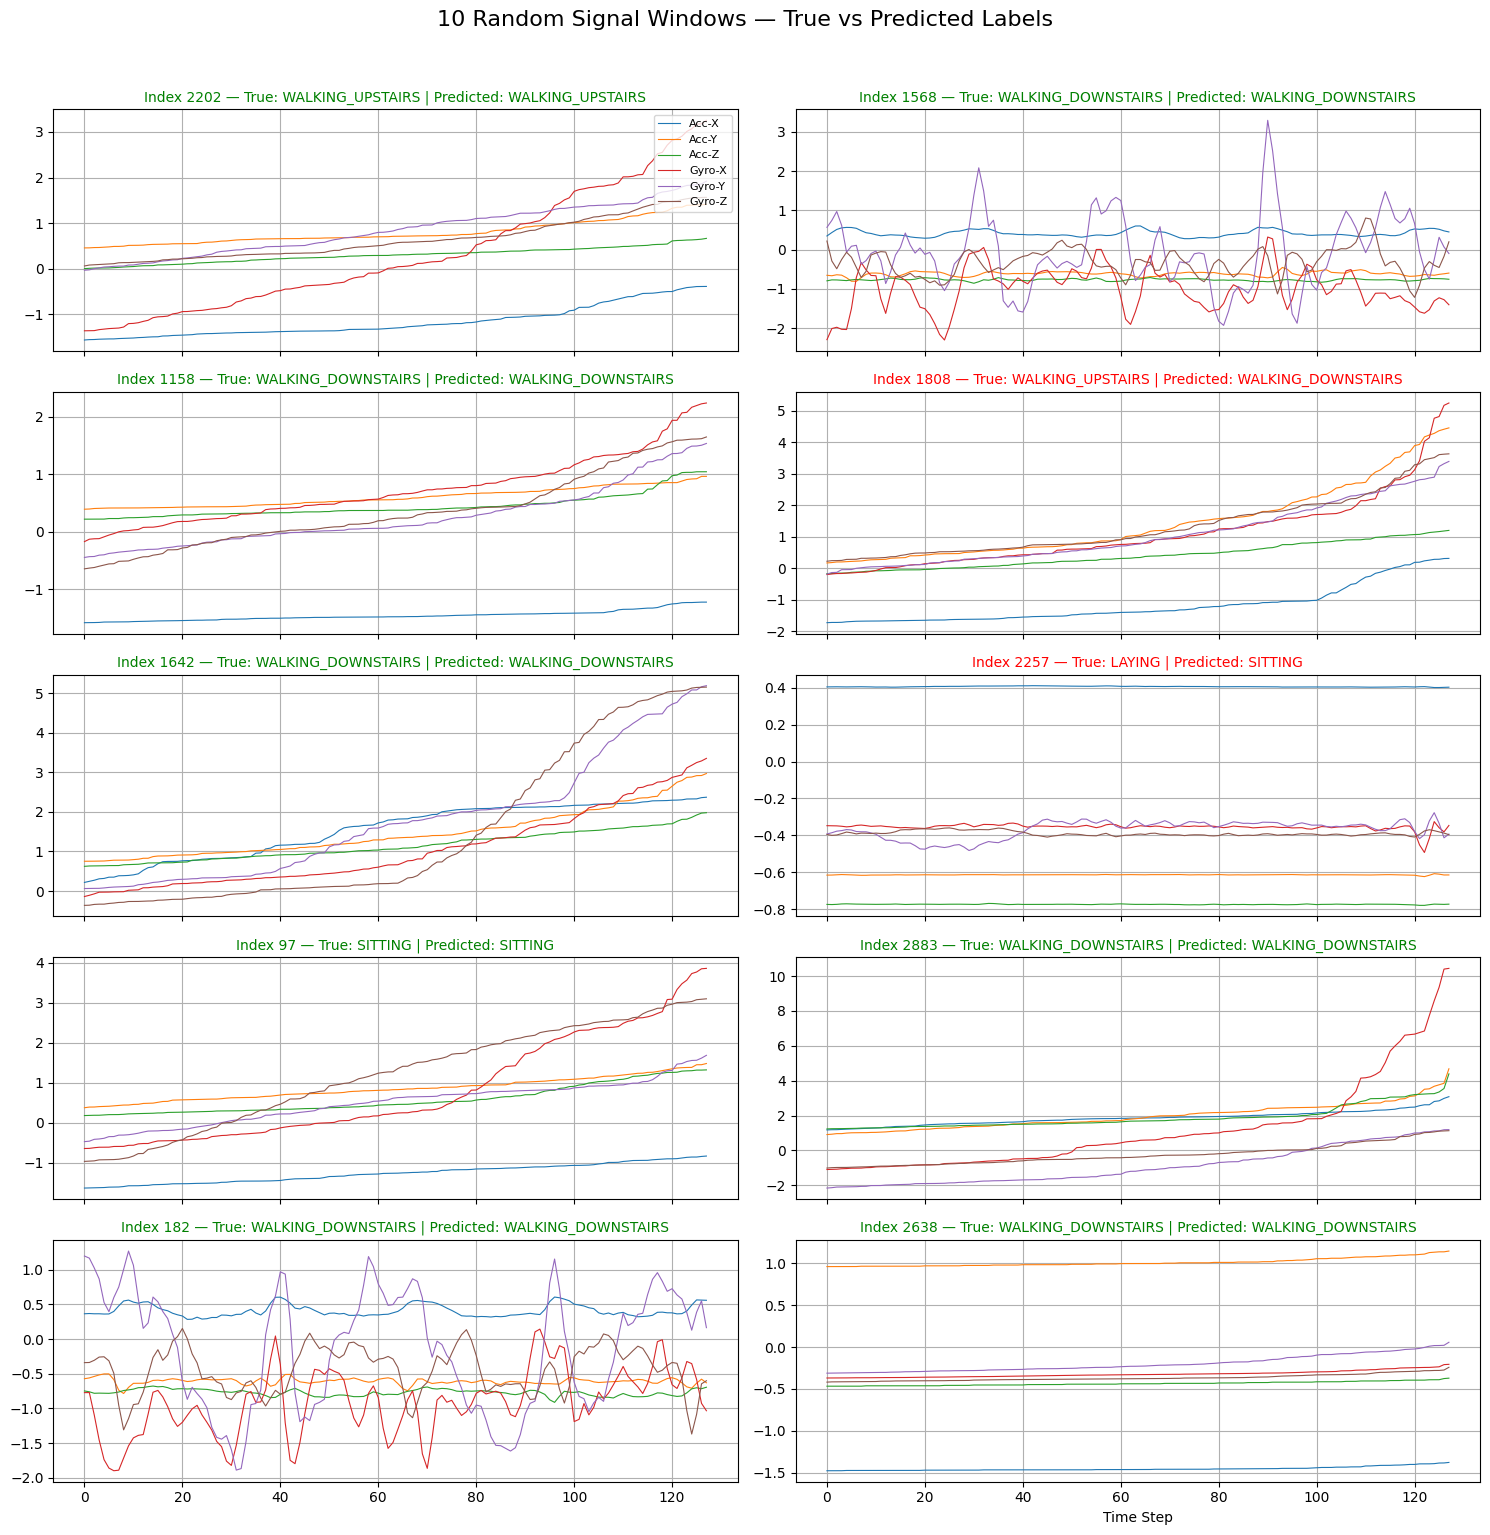

In [ ]:
import matplotlib.pyplot as plt
import random

# Ensure predictions are made
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert y_test from one-hot if needed
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

# Sensor channel labels
sensor_channels = ['Acc-X', 'Acc-Y', 'Acc-Z', 'Gyro-X', 'Gyro-Y', 'Gyro-Z']

# Pick 10 random indices
sample_indices = random.sample(range(len(X_test)), 10)

# Setup subplots (5 rows x 2 cols)
fig, axes = plt.subplots(5, 2, figsize=(15, 15), sharex=True)

for i, idx in enumerate(sample_indices):
    row = i // 2
    col = i % 2
    ax = axes[row, col]

    signal = X_test[idx]
    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred[idx]]

    for ch in range(signal.shape[1]):
        ax.plot(signal[:, ch], label=sensor_channels[ch], linewidth=0.8)

    ax.set_title(f"Index {idx} — True: {true_label} | Predicted: {pred_label}",
                 fontsize=10, color='green' if true_label == pred_label else 'red')
    ax.grid(True)
    if i == 0:
        ax.legend(loc='upper right', fontsize=8)

fig.suptitle("10 Random Signal Windows — True vs Predicted Labels", fontsize=16, y=1.02)
plt.xlabel("Time Step")
plt.tight_layout()
plt.show()
